<a href="https://colab.research.google.com/github/hughjafro/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/Sprint_Challenge/CTolbert_DS41SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [3]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 2.9MB/s 


In [0]:
!pip install dtreeviz

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._





In [6]:
# Check shape
print(train.shape)
print(test.shape)

(51916, 17)
(17306, 17)


In [7]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [8]:
# Check column headings
test.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [9]:
# Check for Nans
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [10]:
# Quick look at the corr matrix
train.corr()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
Inspection ID,1.000000,0.194781,0.000944,0.053912,-0.008544,0.004624
License #,0.194781,1.000000,-0.016444,0.006098,0.035326,0.043235
Zip,0.000944,-0.016444,1.000000,0.185379,-0.399629,0.014190
Latitude,0.053912,0.006098,0.185379,1.000000,-0.430789,-0.014143
Longitude,-0.008544,0.035326,-0.399629,-0.430789,1.000000,0.015747
Fail,0.004624,0.043235,0.014190,-0.014143,0.015747,1.000000


In [11]:
# Review value counts for fail vs not fail
train.Fail.value_counts()

0    38490
1    13426
Name: Fail, dtype: int64

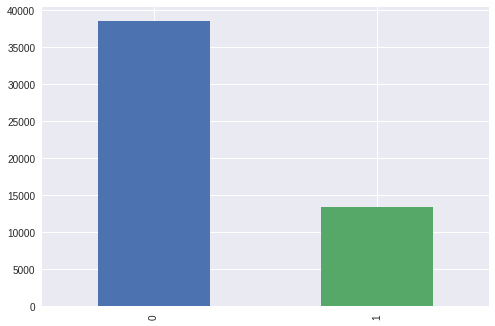

In [12]:
train.Fail.value_counts().plot.bar()

In [0]:
# Define X and y
X_train = train.drop('Fail', axis=1)
X_test = test.drop('Fail', axis=1)

# Target
y_train = train['Fail']
y_test = test['Fail']

In [0]:
# Wrangle X_train and y_train the same way

def wrangle(X):
    X = X.copy()
    
    # Drop columns
    X = X.drop(columns = ['License #','City', 'State', 'Latitude', 'Longitude', 'Location']) 
    
    # Change NaN in facility type to ot defined
    X['Facility Type'] = X['Facility Type'].fillna('Not Defined')
    
    # Change Nan in violations to Incomplete
    X['Violations'] = X['Violations'].fillna('Incomplete')
   
    # Remaining nans are filled with Unknown
    X = X.fillna('Unknown')
            
    # return wrangled data frame
    return X
  
X_train = wrangle(X_train)
X_test = wrangle(X_test)

In [15]:
print(X_train.shape)
print(X_test.shape)

(51916, 10)
(17306, 10)


In [0]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#### Random Forest Improves ROC AUC compared to decion tree

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


In [17]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(
       ce.OrdinalEncoder(), 
       RandomForestClassifier(
       n_estimators=100, 
       class_weight='balanced', 
       min_samples_leaf=0.005, 
       oob_score=True, 
       n_jobs=-1)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ , score=0.642552740681501, total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ....................... , score=0.7130617979566629, total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] ....................... , score=0.7304225915652957, total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.7s remaining:    0.0s


[CV] ....................... , score=0.7313423690305301, total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.6s remaining:    0.0s


[CV] ....................... , score=0.7262873667154834, total=   5.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.4s finished


array([0.64255274, 0.7130618 , 0.73042259, 0.73134237, 0.72628737])

In [0]:
# Check Out of Bag
from sklearn.metrics import roc_auc_score

In [19]:
%%time
pipe.fit(X_train, y_train)
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('ROC AUC, Out-of-Bag estimate:', roc_auc_score(y_train, y_pred_proba))

ROC AUC, Out-of-Bag estimate: 0.7232336372886536
CPU times: user 12.5 s, sys: 48.6 ms, total: 12.6 s
Wall time: 6.68 s


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

#### Feature Importance Viz

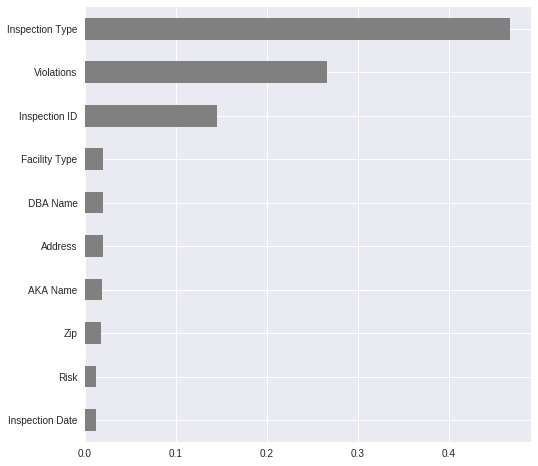

In [20]:
def show_feature_importances(
    pipe, X, y, estimator_name='randomforestclassifier', 
    n=20, figsize=(8, 8)):
    
    # pipe must not change dimensions of X dataframe
    pipe.fit(X, y)
    
    importances = pd.Series(
        pipe.named_steps[estimator_name].feature_importances_, 
        X.columns)

    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='grey')

    
show_feature_importances(pipe, X_train, y_train)

In [22]:
!pip install eli5

    100% |████████████████████████████████| 102kB 3.4MB/s 


In [23]:
%%time
import eli5
from eli5.sklearn import PermutationImportance

encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)

CPU times: user 20.8 s, sys: 267 ms, total: 21.1 s
Wall time: 11.5 s


In [24]:
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.1466 ± 0.0000,Inspection Type
0.0733 ± 0.0000,Violations
0.0518 ± 0.0000,Inspection ID
0.0077 ± 0.0000,Address
0.0071 ± 0.0000,Facility Type
0.0068 ± 0.0000,Zip
0.0064 ± 0.0000,AKA Name
0.0058 ± 0.0000,Risk
0.0055 ± 0.0000,DBA Name
0.0034 ± 0.0000,Inspection Date
